In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose

In [3]:
#%tensorflow_version 2.x
%matplotlib inline

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

print(X_train.shape, '\t', y_train.shape)
print(X_test.shape, '\t', y_test.shape)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28) 	 (60000,)
(10000, 28, 28) 	 (10000,)


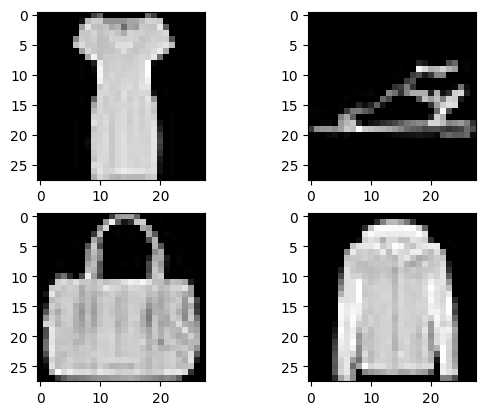

In [5]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[20][:,:,0], cmap='gray')

plt.subplot(222)
plt.imshow(X_train[300][:,:,0],  cmap='gray')

plt.subplot(223)
plt.imshow(X_train[4000][:,:,0],  cmap='gray')

plt.subplot(224)
plt.imshow(X_train[5000][:,:,0],  cmap='gray')
plt.show()

In [9]:
enc_input = Input(shape=(28,28,1), name='encoder input')
x = Conv2D(128, 5, padding='same', activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

enc_shape = tf.keras.backend.int_shape(x)

In [10]:
x = Flatten()(x)
x = Dense(32)(x)

In [11]:
latent_dim = 2 #2D space

z_mean = Dense(latent_dim, name='Z-mean')(x)
z_logvar = Dense(latent_dim, name='Z-logvariance')(x)

In [12]:
def sampling(args):
  mean, logvar = args
  eps = tf.random_normal([latent_dim])
  rnd_sam = mean + tf.exp(logvar/2) * eps
  return rnd_sam

In [14]:
z = Lambda(sampling, output_shape=(latent_dim,), name='latent-space')([z_mean, z_logvar])

In [15]:
encoder = keras.Model(enc_input, z, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder input       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │      3,328 │ encoder           │
│                     │ 128)              │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 14, 14,    │     73,792 │ conv2d_12[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 14, 14,    │     36,928 │ conv2d_14[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 12544)     │          0 │ conv2d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │    401,440 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Z-mean (Dense)      │ (None, 2)         │         66 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Z-logvariance       │ (None, 2)         │         66 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent-space        │ (None, 2)         │          0 │ Z-mean[0][0],     │
│ (Lambda)            │                   │            │ Z-logvariance[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 552,548 (2.11 MB)

 Trainable params: 552,548 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
dec_input = Input(shape=(latent_dim,), name='decoder-input')

true_shape = enc_shape[1:]

y = Dense(np.prod(true_shape))(dec_input)
y = Reshape(target_shape=true_shape)(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, padding='same', activation='relu')(y)
y = Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(y)
y = Conv2DTranspose(128, 5, padding='same', activation='relu')(y)
y = Conv2DTranspose(1, 5, padding='same', activation='relu')(y)

In [17]:
decoder = keras.Model(dec_input, y, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder-input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12544)          │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 128)    │       204,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 1)      │         3,201 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,545 (1.36 MB)

 Trainable params: 356,545 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
enc_output = encoder(enc_input)
dec_output = decoder(enc_output)


vae = keras.Model(enc_input, dec_output, name='VAE')
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │       552,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       356,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 909,093 (3.47 MB)

 Trainable params: 909,093 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def loss_func(z_mean, z_logvar):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = tf.reduce_mean(tf.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(z_mean, z_logvar):
        kl_loss = -0.5 * tf.reduce_sum(1.0 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.reduce_sum(1.0 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))


In [ ]:
history = vae.fit(X_train, X_train, epochs=20, batch_size=32, validation_data=(X_test, X_test))

In [21]:
# Check if TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Check available devices
print("Available devices:", tf.config.experimental.list_physical_devices())

Num GPUs Available:  0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
